## 6. Nonlinear ensemble filtering for the Lorenz-63 problem

In this notebook, we are interested in the sequential inference 



References: 


[1] Evensen, G., 1994. Sequential data assimilation with a nonlinear quasi‐geostrophic model using Monte Carlo methods to forecast error statistics. Journal of Geophysical Research: Oceans, 99(C5), pp.10143-10162.

[2] Asch, M., Bocquet, M. and Nodet, M., 2016. Data assimilation: methods, algorithms, and applications. Society for Industrial and Applied Mathematics.

[3] Bishop, C.H., Etherton, B.J. and Majumdar, S.J., 2001. Adaptive sampling with the ensemble transform Kalman filter. Part I: Theoretical aspects. Monthly weather review, 129(3), pp.420-436. 

[4] Lorenz, E.N., 1963. Deterministic nonperiodic flow. Journal of atmospheric sciences, 20(2), pp.130-141.

[5] Spantini, A., Baptista, R. and Marzouk, Y., 2019. Coupling techniques for nonlinear ensemble filtering. arXiv preprint arXiv:1907.00389.

### The basic steps
To carry out sequential inference in `AdaptiveTransportMap`, we need to carry out a few basic steps:
* **Specify the problem**: Define the state-space model: initial condition, dynamical and observation models (including process and observation noise)
* **Specify the inflation parameters**: Determine the levels of covariance inflation to properly balance the dynamical system and the observations from the truth system
* **Specify the filter**: Choose the ensemble filter to assimilate the observations in the state estimate
* **Perform the sequential inference**: Perform the sequential inference

We will go through all of these here.

In [1]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions
using OrdinaryDiffEq

In [2]:
using DelimitedFiles

Load some packages to make nice figures

In [3]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

The Lorenz-63  model is a three dimensional system that models the atmospheric convection [4]. This system is a classical benchmark problem in data assimilation. The state $\boldsymbol{x} = (x_1, x_2, x_3)$ is governed by the following set of ordinary differential equations:

\begin{equation}
\begin{aligned}
&\frac{\mathrm{d} x_1}{\mathrm{d} t}=\sigma(x_2-x_1)\\
&\frac{\mathrm{d} x_2}{\mathrm{d} t}=x_1(\rho-x_2)-x_2\\
&\frac{\mathrm{d} x_3}{\mathrm{d} t}=x_1 x_2-\beta x_3,
\end{aligned}
\end{equation}

where $\sigma = 10, \beta = 8/3, \rho = 28$. For these values, the system is chaotic and behaves like a strange attractor. We integrate this system of ODEs with time step $\Delta t_{dyn} = 0.05$. The state is fully observed $h(t,\boldsymbol{x}) = \boldsymbol{x}$ with $\Delta t_{obs}=0.1$. The initial distribution $\pi_{\mathsf{X}_0}$ is the standard Gaussian. The process noise is Gaussian with zero mean and covariance $10^{-4}\boldsymbol{I}_3$. The measurement noise has a Gaussian distribution with zero mean and covariance $\theta^2\boldsymbol{I}_3$ where $\theta^2 = 4.0$.

### Simple twin-experiment

Define the dimension of the state and observation vectors

In [4]:
Nx = 3
Ny = 3

3

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [5]:
Δtdyn = 0.05
Δtobs = 0.1

0.1

Define the time span of interest

In [6]:
t0 = 0.0
tf = 100.0
Tf = ceil(Int64, (tf-t0)/Δtobs)

1000

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [7]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)


We construct the state-space representation `F` of the system composed of the deterministic part of the dynamical and observation models. 

The dynamical model is provided by the right hand side of the ODE to solve. For a system of ODEs, we will prefer an in-place syntax `f(du, u, p, t)`, where `p` are parameters of the model.
We rely on `OrdinaryDiffEq` to integrate the dynamical system with the Tsitouras 5/4 Runge-Kutta method adaptive time marching. 

We assume that the state is fully observable, i.e. $h(x, t) = x$.

In [8]:
h(x, t) = x
F = StateSpace(lorenz63!, h)

StateSpace(AdaptiveTransportMap.lorenz63!, h)

Define the additive inflation for the dynamical and observation models

In [136]:
### Process and observation noise
σx = 1e-1
σy = 1e-3

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

AdditiveInflation(3, [0.0, 0.0, 0.0], [1.0e-6 0.0 0.0; 0.0 1.0e-6 0.0; 0.0 0.0 1.0e-6], [0.001 0.0 0.0; 0.0 0.001 0.0; 0.0 0.0 0.001])

In [137]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, π0, 0, 0, 0, F);

To perform the nonlinear ensemble filtering, we first need to estimate the transport map $\boldsymbol{S}^{\boldsymbol{\mathcal{X}}}$.

In this notebook, we are going to assume that the basis of features does not change over time, but solely the coefficients $c_{\boldsymbol{\alpha}}$ of the expansion. 


To estimate the map, we generate joint samples $(\boldsymbol{y}^i, \boldsymbol{x}^i), \; i = 1, \ldots, N_e$ where $\{\boldsymbol{x}^i\}$ are i.i.d. samples from pushforward of the standard Gaussian distribution by the flow of the Lorenz-63 system.

In [138]:
# Number of runs
Ne = 500

# Time span
tspan = (0.0, 100.0)
prob = ODEProblem(lorenz63!, zeros(Nx), tspan)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: [0.0, 0.0, 0.0]

Create cache to store the different final solutions

In [139]:
X = zeros(Ny + Nx, Ne);

Solve Lorenz-96 model for the different initial conditions and store the solutions as the columns of `X`, and compute the associated observation vector.

In [140]:
J = ceil(Int64, (tf-t0)/Δtobs)
@inbounds for i=1:Ne
    xtmp = rand(π0)
    for j=1:J
        tspan = (t0 + (j-1)*model.Δtobs, t0 + j*model.Δtobs)
        prob = remake(prob, tspan = tspan, u0 = xtmp)
        sol = solve(prob, Tsit5(), dt = Δtdyn, dense = false, save_everystep = false)
        xtmp .= copy(sol.u[end]) 
        # Add process noise
        model.ϵx(xtmp)
    end
    
    # Store the state
    X[Ny+1:Ny+Nx,i] .= copy(xtmp)
end
# Generate the observations
observe(h, X, tf, Ny, Nx)

# Apply the observation noise
ϵy(X, 1, Ny)

In [165]:
# writedlm( "lorenzdata.csv",  X, ',')
X = readdlm( "lorenzdata.csv",  ',')

6×500 Array{Float64,2}:
 12.6981    0.930478   3.98214  13.6515  …   5.38257    9.40037  -13.654
  8.37203   1.62649    5.75284  13.2089      0.775109   3.96774  -11.2277
 36.521    10.9611    17.4395   34.3492     29.3109    33.9116    36.3547
 12.6979    0.929687   3.98188  13.6506      5.38174    9.40014  -13.6549
  8.37175   1.62558    5.75274  13.2087      0.774492   3.96771  -11.2286
 36.5206   10.9604    17.4391   34.3489  …  29.3107    33.9112    36.354

In [166]:
# Initialize the map
m = 25
S = HermiteMap(m, X; diag = true, α = 1.0e-4)

HermiteMap(25, 6, LinearTransform(6, [0.4147432940129076, 0.16516928040533463, 23.185696156541045, 0.4142537177229937, 0.16468411727530424, 23.185208293342406], [7.605649175105361 0.0 … 0.0 0.0; 0.0 8.937206142197835 … 0.0 0.0; … ; 0.0 0.0 … 8.937225951689017 0.0; 0.0 0.0 … 0.0 8.356337886751735], true), MapComponent[Map component of dimension 1 with Nψ 1 active features
, Map component of dimension 2 with Nψ 1 active features
, Map component of dimension 3 with Nψ 1 active features
, Map component of dimension 4 with Nψ 1 active features
, Map component of dimension 5 with Nψ 1 active features
, Map component of dimension 6 with Nψ 1 active features
])

In [168]:
Ne

500

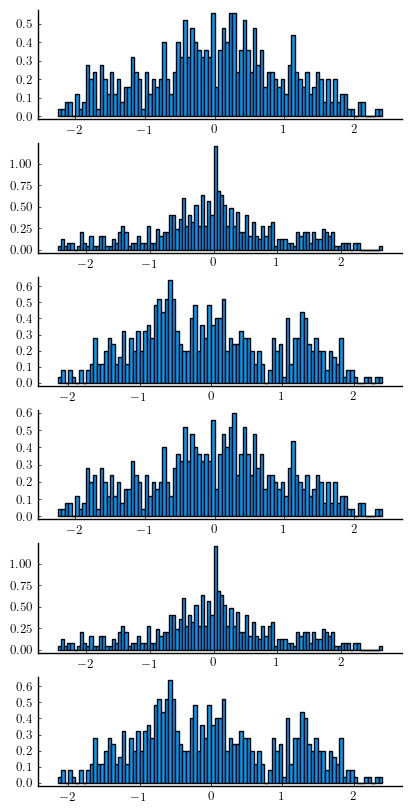

In [169]:
plt = plot(layout = grid(6,1), size = (400, 800))

for i=1:6
      histogram!(plt[i,1], sort(transform(X)[i,:]), bins = 100; normalize = :pdf, legend = false)     
end
plt
# savefig("normalized_histogram.pdf")

In [143]:
transform(X)

6×500 Array{Float64,2}:
 1.61503    0.0678095   0.469045  1.74039  …  0.653177   1.18144   -1.84978
 0.918281   0.16351     0.625215  1.45949     0.0682473  0.425477  -1.27477
 1.59583   -1.46291    -0.687649  1.33593     0.733004   1.28356    1.57594
 1.61506    0.0677698   0.469077  1.74033     0.653132   1.18148   -1.84983
 0.918301   0.163461    0.625256  1.45952     0.0682324  0.425527  -1.27481
 1.59584   -1.46294    -0.687638  1.33596  …  0.733041   1.28357    1.57591

In [160]:
getcoeff(S[3])

22-element Array{Float64,1}:
  93.16492769409697
 -50.15619463912277
 -38.80498552418029
  25.85657457511327
 -21.271300807561673
  15.200031026244204
  -3.3333955715166526
   3.7140892815392386
 -12.091053641860862
   4.724472937499847
 -13.624554908285285
   2.507020557848997
  -2.2148943584305343
   1.1145906075242908
 -14.054234736447668
 -18.352591901684754
  16.169942075480854
  -2.3945063306445324
  -4.633988405407342
  -0.9511850483177496
   2.5700413783275042
   2.3273955808229636

The optimization works up to 22 active features, after the Cholesky decomposition crashes.

In [171]:
@time optimize(S, X, 22; withqr = true, verbose = true, hessprecond = true)

1 terms - Training error: 1.4179385332046732
1 terms - Training error: 1.417886864707796
2 terms - Training error: 1.4157981639810364
3 terms - Training error: 1.4135439016645324
4 terms - Training error: 1.4121406929748628
5 terms - Training error: 1.4115724324454937
6 terms - Training error: 1.3804128882754851
7 terms - Training error: 1.3790214531868301
8 terms - Training error: 1.3787373402519847
9 terms - Training error: 1.3787360035830798
10 terms - Training error: 1.378735480812081
11 terms - Training error: 1.378663833273354
12 terms - Training error: 1.3786598111543922
13 terms - Training error: 1.3784713976761187
14 terms - Training error: 1.3783978414622888
15 terms - Training error: 1.3782433685826818
16 terms - Training error: 1.377840211465942
17 terms - Training error: 1.3778140310304556
18 terms - Training error: 1.3771351557369966
19 terms - Training error: 1.3771267955086712
20 terms - Training error: 1.376684676864672
21 terms - Training error: 1.3766530798476488


Progress:  17%|██████▉                                  |  ETA: 0:00:05

22 terms - Training error: 1.3765086318408313
1 terms - Training error: 1.4179385332046728
1 terms - Training error: 1.417876018945938
2 terms - Training error: 1.0742529520614625
3 terms - Training error: 1.0742127244556938
4 terms - Training error: 1.0366709893963149
5 terms - Training error: 1.0365704025819875
6 terms - Training error: 0.7864349280713125
7 terms - Training error: 0.7840218763271446
8 terms - Training error: 0.7341024749119388
9 terms - Training error: 0.7336477331626619
10 terms - Training error: 0.6534919100623345
11 terms - Training error: 0.6510399423128481
12 terms - Training error: 0.6351556520471722
13 terms - Training error: 0.6316918195248713
14 terms - Training error: 0.6292065006423666
15 terms - Training error: 0.6277018504649576
16 terms - Training error: 0.5475892949335515
17 terms - Training error: 0.5120562435139903
18 terms - Training error: 0.5017626301177625
19 terms - Training error: 0.5007871764698297
20 terms - Training error: 0.4999855217096373

Progress:  33%|█████████████▋                           |  ETA: 0:00:04

21 terms - Training error: 0.48522877219444516
22 terms - Training error: 0.47995497979057883
1 terms - Training error: 1.4179385332046728
1 terms - Training error: 1.4078185756635184
2 terms - Training error: 1.1372156662345754
3 terms - Training error: 1.0479791013720638
4 terms - Training error: 0.8920086831805166
5 terms - Training error: 0.8699494167003657
6 terms - Training error: 0.8448560681046455
7 terms - Training error: 0.5201346175662024
8 terms - Training error: 0.5030282799419599
9 terms - Training error: 0.4925796008052932
10 terms - Training error: 0.4915936404496708
11 terms - Training error: 0.48199083395979986
12 terms - Training error: 0.47214200675604384
13 terms - Training error: 0.4476867250771303
14 terms - Training error: 0.44623682917624735
15 terms - Training error: 0.42034205512150313
16 terms - Training error: 0.3402418005100935
17 terms - Training error: 0.30983260245615774
18 terms - Training error: 0.30798751502349664
19 terms - Training error: 0.3065968

Progress:  50%|████████████████████▌                    |  ETA: 0:00:02

21 terms - Training error: 0.21270130435189552
22 terms - Training error: 0.16492655230706882
1 terms - Training error: 1.4179385332046728
1 terms - Training error: 1.417825869431766
2 terms - Training error: 0.9635878776064346
3 terms - Training error: 0.9633918054947994
4 terms - Training error: 0.9204508088848845
5 terms - Training error: 0.9197431854939736
6 terms - Training error: -0.4530883401176555
7 terms - Training error: -0.4560136523377813
8 terms - Training error: -0.5755605275136759
9 terms - Training error: -0.5976259249326682
10 terms - Training error: -3.2703978422908855
11 terms - Training error: -3.273192178308206
12 terms - Training error: -3.3300910916783657
13 terms - Training error: -3.3302390186053885
14 terms - Training error: -3.33910344359716
15 terms - Training error: -3.3444146705720272
16 terms - Training error: -3.428501523753823
17 terms - Training error: -3.428505320478251
18 terms - Training error: -3.4294046959143403
19 terms - Training error: -3.42940

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:02

22 terms - Training error: -3.4317396700855634
1 terms - Training error: 1.4179385332046728
1 terms - Training error: 1.4178760206813723
2 terms - Training error: 1.074252153189579
3 terms - Training error: 1.074211930862518
4 terms - Training error: 1.036670804849227
5 terms - Training error: 1.0363450022998297
6 terms - Training error: 1.0344861318111385
7 terms - Training error: 1.0318305530609786
8 terms - Training error: 0.9570252070090908
9 terms - Training error: 0.9567090168472101
10 terms - Training error: 0.9563985711905413
11 terms - Training error: 0.9563102989147548
12 terms - Training error: 0.9218119895782635
13 terms - Training error: 0.9215946193180181
14 terms - Training error: 0.9215505112986027
15 terms - Training error: 0.9215260271378584
16 terms - Training error: -0.3718728536865203
17 terms - Training error: -0.37376402534324027
18 terms - Training error: -0.37798074265277015
19 terms - Training error: -0.3784861959650988
20 terms - Training error: -0.5025463812

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:01

22 terms - Training error: -1.9791182782281924
1 terms - Training error: 1.417938533204673
1 terms - Training error: 1.4078185317990202
2 terms - Training error: 1.1372145969477059
3 terms - Training error: 0.9970616457251098
4 terms - Training error: 0.9410858475264098
5 terms - Training error: 0.9390815590252656
6 terms - Training error: 0.9381350936875695
7 terms - Training error: 0.9202042665385209
8 terms - Training error: 0.9159081623329335
9 terms - Training error: -0.587351948626735
10 terms - Training error: -0.6657983670245594
11 terms - Training error: -3.367198620883546
12 terms - Training error: -3.3673193209004038
13 terms - Training error: -3.3971330658431587
14 terms - Training error: -3.3977193442480287
15 terms - Training error: -3.4008620288614586
16 terms - Training error: -3.4008892402624435
17 terms - Training error: -3.400890706588223
18 terms - Training error: -3.4010261223844584
19 terms - Training error: -3.40249603695316


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


20 terms - Training error: -3.403105846249294
21 terms - Training error: -3.403177053794188
22 terms - Training error: -3.403221937342768
  4.302081 seconds (958.87 k allocations: 3.881 GiB, 4.45% gc time)


HermiteMap(25, 6, LinearTransform(6, [0.4147432940129076, 0.16516928040533463, 23.185696156541045, 0.4142537177229937, 0.16468411727530424, 23.185208293342406], [7.605649175105361 0.0 … 0.0 0.0; 0.0 8.937206142197835 … 0.0 0.0; … ; 0.0 0.0 … 8.937225951689017 0.0; 0.0 0.0 … 0.0 8.356337886751735], true), MapComponent[Map component of dimension 1 with Nψ 22 active features
, Map component of dimension 2 with Nψ 22 active features
, Map component of dimension 3 with Nψ 22 active features
, Map component of dimension 4 with Nψ 22 active features
, Map component of dimension 5 with Nψ 22 active features
, Map component of dimension 6 with Nψ 22 active features
])

In [172]:
# Conditioning number of the basis evaluation on the different samples
cond(evaluate_basis(S[1].I.f.f,  transform(X[1:1,:])))

2.3452463726273026e11

In [173]:
stor = Storage(S[1].I.f, transform(X[1:1,:]))
q = QRscaling(stor)

QRscaling([-22.36067977499789 -0.7192395394428297 … -1.7448382213377636 0.1918198021006985; 0.0 -22.34910947856541 … -0.10085182418038863 -3.6219196795902873; … ; 0.0 0.0 … -3.770947082817074e-7 -9.456935226875807e-8; 0.0 0.0 … 0.0 -8.723304341781637e-8], [-0.04472135954999581 0.0014392237899610878 … -888165.8466334076 1.0210359210916412e6; 0.0 -0.0447445121229139 … 873166.9541315784 -1.3099622443558645e7; … ; 0.0 0.0 … -2.65185370687555e6 2.8748749045651886e6; 0.0 0.0 … 0.0 -1.1463545931904987e7], [0.525992748576151 0.0 … 0.0 0.0; 0.0 0.3836867233680237 … 0.0 0.0; … ; 0.0 0.0 … 0.18247006849298733 0.0; 0.0 0.0 … 0.0 0.1906688743662787], [1.9011668938535267 0.0 … 0.0 0.0; 0.0 2.6062929444676732 … 0.0 0.0; … ; 0.0 0.0 … 5.480350877593011 0.0; 0.0 0.0 … 0.0 5.2446945172549775], [-11.76155541488229 -0.2759626622055458 … -0.3183807497566839 0.03657406574770252; 0.0 -8.575056586024003 … -0.01840243926583823 -0.6905873483525529; … ; 0.0 0.0 … -6.880849724850622e-8 -1.8031431946632186e-8; 0.0

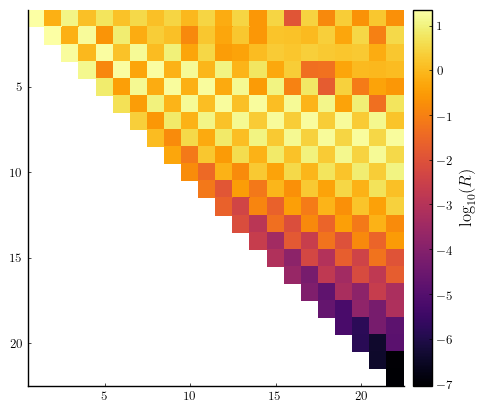

In [175]:
heatmap(log10.(abs.(q.R)), yflip =true, ratio = 1, colorbartitle = L"\log_{10}(R)")
savefig("R_matrix.pdf")

In [148]:
cond(q.R)

2.691972038436223e6

In [149]:
getcoeff(S[3])

22-element Array{Float64,1}:
  93.16492769409697
 -50.15619463912277
 -38.80498552418029
  25.85657457511327
 -21.271300807561673
  15.200031026244204
  -3.3333955715166526
   3.7140892815392386
 -12.091053641860862
   4.724472937499847
 -13.624554908285285
   2.507020557848997
  -2.2148943584305343
   1.1145906075242908
 -14.054234736447668
 -18.352591901684754
  16.169942075480854
  -2.3945063306445324
  -4.633988405407342
  -0.9511850483177496
   2.5700413783275042
   2.3273955808229636

In [150]:
cond(evaluate_basis(S[6].I.f.f, X[1:6,:]))

7.61873006255153e15

In [151]:
q.R

22×22 UpperTriangular{Float64,Array{Float64,2}}:
 -22.3607  -21.5642    4.11089  -21.5642       …   6.50133       -5.57722
    ⋅        5.91475   7.53781    5.91475          7.44733      -12.0803
    ⋅         ⋅       20.6466    -1.58604e-6      19.4036        -6.22914
    ⋅         ⋅         ⋅         0.000280228      0.186214       0.0360785
    ⋅         ⋅         ⋅          ⋅               0.225447       0.701652
    ⋅         ⋅         ⋅          ⋅           …   3.56205       13.22
    ⋅         ⋅         ⋅          ⋅              -0.455627      -0.341591
    ⋅         ⋅         ⋅          ⋅               0.310193       0.134659
    ⋅         ⋅         ⋅          ⋅               0.0539019      2.59981
    ⋅         ⋅         ⋅          ⋅              -0.291738       0.661063
    ⋅         ⋅         ⋅          ⋅           …  -1.52111        5.56215
    ⋅         ⋅         ⋅          ⋅              -2.11796        8.33886
    ⋅         ⋅         ⋅          ⋅               0.0594005 

In [152]:
P = zeros(ncoeff(S[1]), ncoeff(S[1]))
precond!(P, getcoeff(S[1]), stor, S[1], X[1:1,:])

Pqr = zeros(ncoeff(S[1]), ncoeff(S[1]))
qrprecond!(Pqr, q.U*getcoeff(S[1]), q, stor, S[1], X[1:1,:])

LoadError: [91mAssertionError: Wrong dimension of the Vander matrix[39m

In [153]:
cond(P)

Inf

In [154]:
cond(Pqr)

LoadError: [91mUndefVarError: Pqr not defined[39m

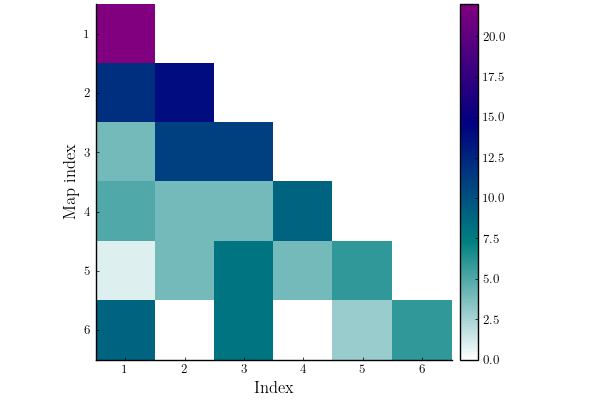

In [155]:
plot(S)

In [156]:
Ωhat = zeros(Ny + Nx, Ny + Nx)
cache = zeros(1, Ny + Nx, Ny + Nx)
for i=1:Ne
    hess_x_log_pdf!(cache, S, X[:,i:i])
    Ωhat .+= copy(cache[1,:,:]).^2
end
rmul!(Ωhat, 1/Ne)

6×6 Array{Float64,2}:
 NaN          NaN    NaN           NaN       NaN         1.22385e6
 NaN          NaN    NaN           NaN       NaN         0.0
 NaN          NaN    NaN           NaN       NaN         5.03868e13
 NaN          NaN    NaN           NaN       NaN         0.0
 NaN          NaN    NaN           NaN       NaN    572504.0
   1.22385e6    0.0    5.03868e13    0.0  572504.0       5.04991e13

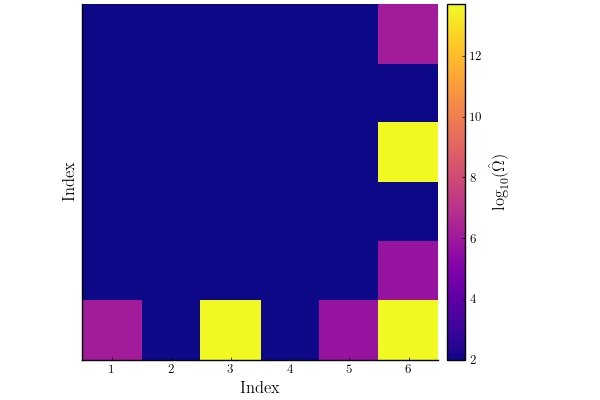

In [157]:
plt = plot()

heatmap!(plt,log10.(Ωhat), ratio = 1, yflip = true, 
        colorbar = true, color = :plasma, clim = (2.0, Inf), colorbar_title = L"\log_{10}(\hat{\Omega})",
        xlabel = "Index", ylabel = "Index", background_color_inside = palette(:plasma)[1], 
        yticks = (reverse(collect(0:10:Nx))))
plt

The rest is work in progress

In [24]:
smf = StochMapFilter(x->x, ϵy, deepcopy(S), Ny, Nx, Δtdyn, Δtobs, 2*Δtobs, false)

Stochastic Map Filter with filtered = false


Set initial condition of the true system

In [26]:
x0 = rand(model.π0);

In [21]:
data = generate_lorenz63(model, x0, Tf);

Initialize the ensemble matrix `X` $\in \mathbb{R}^{(N_y + N_x) \times N_e}$.

In [22]:
Ne = 300 #ensemble size
X = zeros(model.Ny + model.Nx, Ne)

# Generate the initial conditions for the state.
viewstate(X, model.Ny, model.Nx) .= rand(model.π0, Ne)

3×300 view(::Array{Float64,2}, 4:6, :) with eltype Float64:
 -0.687601  -0.254959    0.188217  …   0.103389  -1.39479    2.42032
 -0.500857   0.0862766   0.539567     -0.706949  -1.24376    0.537605
 -0.259377  -0.932509   -0.885783     -1.78774    0.280541  -0.325018

In [113]:
Xsmf = seqassim(F, data, 200, model.ϵx, smf, deepcopy(X), model.Ny, model.Nx, t0);

t = 0.1
getcoeff(M[6]) = [22.906865689731593, -19.377717740394523, 10.573024727789972, -9.986484533334767, 3.789827849345462, -5.217265100003962, -14.799818180191068, 11.06966570625046, 5.104130804711312, -9.019431424029612, 8.458281825773383, -4.806407518503932, -6.787279698165868, 0.5787759515689187, -5.161107934580359, 7.957617637274662, 3.275835920925548, -1.6247206443015998, 0.5633631184716991]
t = 0.2
getcoeff(M[6]) = [17.85023078671892, -11.000248348440945, 5.1987108032508935, -10.629238604398909, 1.7875722195231427, -5.687282299529215, -12.604635247248655, 11.85103933908719, 0.3937244075759413, -8.110224791605425, 10.264114923199173, -0.3859148017272309, -5.712876954409625, 0.2707366875331302, -5.667536310421616, 8.180916001757126, 6.303170658169496, -2.3939506752611965, 2.4915031788578834]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


t = 0.30000000000000004
getcoeff(M[6]) = [11.266448824556152, 1.7164665570652637, 5.493215062828817, 3.492243552104856, -11.534891827906172, 0.40325664305245545, -10.578332655904953, -0.9692287045962255, -14.641361586766186, 1.6375096614555713, 4.498063811610749, -3.2666620550642813, -14.66832552870519, -2.0007712886552236, -6.24453941249212, -0.21700402237023336, 2.3343918353338977, -0.2464175487336985]
t = 0.4
getcoeff(M[6]) = [-12.021032884579379, 2.5879410077941563, -6.956304912161971, 1.404471658379549, 12.132333272675098, 2.4410590391182008, 7.50348577573972, 2.976039830233105, 4.343685759901692, -2.302041053411168, 0.549313380743777, 2.5024609093542183, 1.4612213537601701, 0.7007610900604446, 0.24583252057363303, -0.31533330637169915, -0.2329174466353028, -0.10016006147422259]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


t = 0.5
getcoeff(M[6]) = [1.4812111545232898, -20.57274116122881, -1.2913346076302197, 6.047350903729115, -0.337767226969654, 2.127036820875832, -4.906151978010623, 4.602846602378159, 0.40760652593624125, 1.6580088144440814, 0.41541177913674, -4.173677299682894, 36.26542490030028, -0.19414544215102456, 2.7953778637267717, 13.848169504097127, -1.8079957931143913, -0.4305622856066912, 0.8803636490258625]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 0.6000000000000001
getcoeff(M[6]) = [-35.463927338316736, -9.50059874176015, -11.805736500765521, -1.4874680158739193, 1.1528544680000143, 1.7743306672364583, 6.862852603328631, 4.759929812548403, 2.1512600596491107, 1.6652046925407153, 2.281774371535699, 5.770252318162928, 9.67558338671935, 0.22386177695056067, 17.2752240539691, 8.721888247810433, 2.6145679834708178, 0.14284458484006124, 8.413548082746063]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 0.7000000000000001
getcoeff(M[6]) = [36.83276159205395, -24.951402390235423, 19.16806103593491, -13.51548058999118, 12.317189233360166, -8.382196278455845, -2.2999871675807455, 0.2850141031090243, -0.6673083064168583, -0.13501825269556278, -0.7396320810557167, -6.298258634467871, 17.461501486017063, 0.3504164233661924, -28.808657059272594, 7.627907065985614, 0.030494024287174293, -0.29947724884946014, -12.42370599360083]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 0.8
getcoeff(M[6]) = [4.565433754241828, 2.3294224479770222, -1.8633564627089911, -2.401907068813655, -2.8168366845668156, -2.015384250214061, 0.46498936314223244, -8.381394538274686, -2.2467048192599233, -3.1381345824189397, -2.0508705575482478, 0.7932128865144152, -8.076394028860504, -0.7333633198845051, 1.4108620580107984, 6.903021746153281, 0.4359847200774525, -0.6869085780471993, 0.6019815130458351]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


t = 0.9
getcoeff(M[6]) = [0.10479994620853317, 2.0405092283807296, 2.139577749161759, -11.218773917595936, -6.1992102404451614, 2.112253510249005, 1.3402048390508912, 1.2076840207402293, 10.820803728091597, 9.190205065015583, 5.7866667931292755, 7.773620488345616, -3.967981022146112, -2.562361983118858, 0.6050288957650488, -0.15180562362082362, 1.5687059669549537, 2.1136114479741113, 0.6123826601023]
t = 1.0
getcoeff(M[6]) = [-6.04324140088469, -4.253811249057945, -3.1948133209383247, 2.596607139912836, -1.9021480871798437, -5.118104218906908, -1.0545580574863993, -2.3343850599312503, 2.4399889880769643, 3.9723476806112488, 2.754664312552088, 3.4434424515340374, 0.8150531876189495, -1.8064214492069208, 0.9398983863741891, -0.3488234493780035, 1.741653963014106, 1.2162823299090404, 0.15398714732793878]
t = 1.1
getcoeff(M[6]) = [-5.031263233609694, -9.273743995191236, -1.580877567316259, 6.973842266985953, -1.516497258783924, -7.11732744351757, -0.9813977394543284, -2.1794474913818793, -

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


t = 1.7000000000000002
getcoeff(M[6]) = [16.240779734894538, 2.753274737696811, 11.127393193894278, 5.404941785584658, 4.454684914563776, 2.208678055259212, -4.904501157643727, -0.5711720428478302, -9.510699325816615, 0.23577656212377193, -3.37619342551989, 0.5058630987082465, -1.0511347354982659, 0.508218464725001, 0.6407263832415041, -0.24312841739799934, -0.6663669614003553, 0.4652505753543059, -1.636739117103299]
t = 1.8
getcoeff(M[6]) = [15.81106741790238, 1.7081342732414893, 9.707773419502708, -0.20920059484824952, 2.5053054079141126, -0.10967308154310834, -2.2423424765492186, -0.5698653184319518, -0.7875799008872055, -0.4802464265480154, -0.2624637785951831, -0.2720778956882433, -12.543345774321057, -2.3825058517936477, 0.6366551813603458, -0.2122727261428163, -5.215718873384914, -2.807802859688789, -0.614468152187268]
t = 1.9000000000000001
getcoeff(M[6]) = [-0.7142979739344772, 1.9427317760694047, -3.0567942037186806, 2.738588534230587, -0.30187646579803873, 1.2742731175995052

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


t = 3.3000000000000003
getcoeff(M[6]) = [-6.085900633339495, 4.080932378975479, -4.5314921976379745, -6.651111340251221, 0.3931226950206943, 15.688898938822392, -4.356015553839515, 10.380928274573629, -5.025293516846164, 7.041750819063172, 2.224872185923541, -3.6837171803065196, 0.6489313218799471, -1.5627542332708342, 2.081082311512999, -1.3484115947775916, -3.956068684651415, 0.8401606230353779, -1.4772026383680372]
t = 3.4000000000000004
getcoeff(M[6]) = [-1.7952107146621756, 1.3554786403100758, -0.7549462391861967, -2.6624092439004543, 0.1293686804564897, 7.127284906960041, -4.137949644751515, 7.739264419055421, -8.062031921630892, 7.088482777070861, 0.7820077119855762, -0.38731024071205405, 0.06493214434037048, -4.15236210633801, 3.1485719640823993, 0.24747229615245994, -1.5294661167570611, 1.1067761511256464, -0.11753842692947533]
t = 3.5
getcoeff(M[6]) = [-21.18835519886454, 3.919163051935475, -9.166959777082706, -3.8545305696952026, -0.11009430412715424, 8.4992398257696, -4.080

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 3.6
getcoeff(M[6]) = [10.961568288334483, 4.608501878853842, 2.5649160201387384, 1.3971940185094347, -0.3954017243731065, 8.84809973486096, -1.9901458060212531, 4.672924326843006, -1.5617457287523717, 2.422698741957526, 2.5586856864751786, 1.2460405061085247, 0.0008791667248767565, 0.3430571448412561, 1.3136152612344814, 0.13322829224162325, -22.89583614456241, 0.5943241365996197, -9.358645197877797]
t = 3.7
getcoeff(M[6]) = [6.888864014406584, 7.16110175626948, 2.508261580866249, 8.860465565459986, -0.850568388627718, -0.6535050317555609, -2.045480885412453, -1.0251196497735542, -2.3712982582437783, -0.7111834908697166, 2.8979246935431413, 4.457003590356256, -1.0151589542912796, -0.35599428931672006, 0.052372175931808096, 1.338793242300031, -14.79575092808284, -4.660899153516263, -5.160846716437222]
t = 3.8000000000000003
getcoeff(M[6]) = [-3.3679745765970592, 6.088977554581177, -3.62414731561908, -14.55734009655886, 0.00526800883508477, 4.934767814525912, -2.750087481477597, 4.48

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 5.1000000000000005
getcoeff(M[6]) = [-2.635115604617946, 3.259383219670261, -0.7726539703696274, 2.169534025925637, 0.06400892422531496, -1.9736579465384076, -4.755803829147008, -1.8884093967630768, -4.451670380827411, -2.1468151924882015, 1.1773959315194076, 0.17322884887640233, 0.060355314396875304, -1.1557106428986714, -0.797579919152261, -0.4372877662773053, 1.991369233726076, 0.8895944188683297, 0.5130631671910988]
t = 5.2
getcoeff(M[6]) = [0.6109979746617218, 3.215449767544893, -0.0016929158449054422, -2.0384014927486427, 0.42363287221275403, 0.3353357116988644, -2.900860461349117, 6.462709956886907, -4.577061176682111, 10.594785478467323, 0.4250341251616511, -1.6439759943310168, 0.39367206936232035, -1.5785797309529803, 5.834644794807058, -0.5452378785772948, 2.0336836908352445, 2.9492036156676957, 0.9255195700775186]
t = 5.300000000000001
getcoeff(M[6]) = [-4.8243968837914455, 1.3997876294061604, -6.063055614303279, -11.998225065836042, -0.2817661243384635, 14.3933221994221

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 5.7
getcoeff(M[6]) = [-14.015622618442134, 9.017571567447671, -4.2104808445376, 1.836602472351366, 0.13518697938135144, -2.3417147055512055, -5.618722590171722, -0.7608571165766809, -5.360488976892056, -1.125013296317668, 4.1999305987357065, 1.4499119929740738, -0.0757071547006126, -1.9837963988627012, -1.6541603916776328, 0.9820395960334811, 13.651263523530766, 3.2773242590133727, 3.0044361451489325]
t = 5.800000000000001
getcoeff(M[6]) = [0.9072631635692265, 1.9472864826755578, -0.2569026808466893, -2.353711531533257, -0.6601680060127978, -1.509025709308327, -3.815146966013972, -0.17333016724908656, -5.309099386227708, 0.4567385759032456, 0.9207513500423667, -0.6810856757308157, -0.6081442773447763, -2.0307800102104867, 0.27324311016701075, 0.500920793566277, 3.032432411337262, -0.4026983189172326, 1.618807702693217]
t = 5.9
getcoeff(M[6]) = [4.370833395088064, 2.986902476877143, 2.1498134847771184, 6.499780640599392, 0.7220216216165163, -6.323885029414955, -5.562385495127881, -2

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 6.300000000000001
getcoeff(M[6]) = [-3.997413711771021, 13.4807834141093, -1.3813152163957072, 6.22140991619135, 1.1621333677923456, -8.5730850049266, -5.053973969844967, -6.795308275366555, -2.9224001898545366, -6.292217632106094, 5.812708625833964, 3.995539098160839, 1.4621358302172784, 0.6680834155462363, -2.6857215708024214, 1.4775350171181658, 5.682555089268931, 8.580931944023101, 1.90403200872905]
t = 6.4
getcoeff(M[6]) = [-0.5917967643434459, 2.496610703183193, 0.007426761394741327, -0.5798178512842624, -0.2566079368325596, 3.844179455195965, -4.166242528270152, 2.820079299554281, -4.969768163085823, 2.0173569211226483, 1.6170039365838942, 0.3475629751045034, 0.011760898560819563, -2.1128669216556073, 0.9911854398881061, 0.7181230670982183, -2.106852141072374, -0.40404640522007745, -0.6467892777544653]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


t = 6.5
getcoeff(M[6]) = [7.9403032652571195, -2.2628501799739853, -22.49298075267149, 2.6724202867989297, 14.198685947225986, 2.4732931101221327, -14.680752088511374, 2.910951642186377, 2.986462366132087, -1.117320438003481, -9.603000126171263, 6.788870400919036, 0.27643505198057183, 1.8342599991543032, 0.6467246791665586, -0.3552340449971332, -0.023474328549795795, -3.1934002733061524, -0.41617045105275546]
t = 6.6000000000000005
getcoeff(M[6]) = [-8.87524180931102, 0.036594813108350374, 16.411360900752094, 1.3022095363477755, -6.814397914417603, 0.7926539032716039, 10.320323887585838, 2.7162233346800027, -2.545272579040214, 0.08096028348957822, 4.984110741940566, -3.8314718900317173, -0.8310778105261747, -1.6299945140836487, 1.6357592141735389, -0.012705447656636221, 0.16106280594830605, 0.9694030094903481, -0.3364862070455417]
t = 6.7
getcoeff(M[6]) = [-21.118619386949543, 0.6785681857442867, 18.653635741847193, -0.14252549946236723, 4.579812963405576, 1.8800305401130446, 11.850510

t = 8.5
getcoeff(M[6]) = [5.058104764553865, 6.126442975956429, -12.224218467590408, 0.39023843257021523, 7.7170892879970765, 6.142396531805749, -3.614055849237954, 1.3477270138062372, 1.7591990903259347, 3.023030343003145, 4.065305111457187, 5.472304112950203, 4.52031846241044, 2.106914333561585, 0.988438148071948, 0.10627097650109582, -0.03204783131829077, 4.046506177182476, 1.4353328531222205]
t = 8.6
getcoeff(M[6]) = [6.141677114131798, -1.5672981860205537, -27.422298568116286, -0.7063143237365509, 21.074439084368034, 2.07284891493673, -14.569208527967355, -1.1606161226372416, 0.7790004939811674, -0.7646028478635787, -5.240452333381095, 10.013400778114518, 1.4265278717913716, 1.961169381919871, 0.2655197261204615, -0.33186320887268017, -0.09832234338217959, -0.5634420080698823, 1.5491215481657126]
t = 8.700000000000001
getcoeff(M[6]) = [46.14992191555025, 9.927098137518659, -0.5023440535306471, -3.0605779003951916, -47.59100807342954, 12.836787213460992, 0.35866373131512896, -6.335

t = 10.600000000000001
getcoeff(M[6]) = [-1.5216910389516602, 0.6402262595312243, 0.7944489361018616, 1.678777695781111, 1.446354658433854, 0.8908024131180967, 3.961806271164352, 4.020897551764961, -0.5416427778273949, 0.3061247825810473, 6.099435899248736, -0.6790109635799078, 1.5490566066117148, -0.6535352709973022, 2.9691460371053715, -0.47498730354944924, 0.11673409680774652, 3.3767022193249105, 0.5110521094860654]
t = 10.700000000000001
getcoeff(M[6]) = [2.418574442212733, 0.4121443545035912, -6.261551515373374, 0.9086379147858681, 3.38429052581146, 0.2609987058822719, -5.348686702765683, 1.5126346444617464, 1.106819176517067, -0.13620309224896776, -3.7579143886782447, 1.5882798409935093, -0.10838743731283257, 0.5898502787579502, 0.5968476487537444, 0.009099069522303096, 0.2867799176699296, -1.6594691316754762, -0.4845385217842395]
t = 10.8
getcoeff(M[6]) = [2.071206113903167, 3.5228019932331804, -1.9921376234988157, 0.6048091041361059, -0.24456008706290078, 3.324630293646372, -5.

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 11.8
getcoeff(M[6]) = [-5.469519285820407, 2.0990819335115782, 7.857766210788713, -1.7279760809094287, -4.766883280162924, 3.0602969983111654, -6.573392824153872, -3.6016545884782674, -1.578137299618098, -0.0298593402027102, -14.760818677431725, -2.17086229165443, 4.200096145891642, -0.20522610679691633, -2.023619116057716, 0.3272579692805943, 0.00834364200686141, -6.759277526160492, 1.960310322721944]
t = 11.9
getcoeff(M[6]) = [-9.845042457856723, 3.6038207310495016, 6.75394365981151, 0.8611735354022676, 5.9072805550168015, 5.3791385077533, 13.088394971435763, 1.740389641153707, -1.8385458725665977, 0.9818433211249874, 17.72388599702033, 3.311576267396134, 3.585078687713686, 1.1300265267004956, 1.5981052664094952, 0.08570721896558871, -0.007072316696698734, 8.761531396005477, 0.5764527521278098]
t = 12.0
getcoeff(M[6]) = [-7.985083828552651, 6.033765430922351, 5.53711812529081, -0.1279589529319527, 4.5102923212561015, 5.03192380824692, 9.42176129148425, -0.1778350014143839, -1.728

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


t = 12.9
getcoeff(M[6]) = [0.015507768028422185]
t = 13.0
getcoeff(M[6]) = [-0.06433896732776337]
t = 13.100000000000001
getcoeff(M[6]) = [-0.07504839075399962]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 13.200000000000001
getcoeff(M[6]) = [-0.2560454382918119]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 13.3
getcoeff(M[6]) = [-0.22769392513153408]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 13.4
getcoeff(M[6]) = [0.11447033909749113]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 13.5
getcoeff(M[6]) = [-0.12245418722883814]
t = 13.600000000000001
getcoeff(M[6]) = [-0.1579597576069962]
t = 13.700000000000001
getcoeff(M[6]) = [-0.007187243676312373]
t = 13.8
getcoeff(M[6]) = [0.182379148998432]
t = 13.9
getcoeff(M[6]) = [0.0681924723314449]
t = 14.0
getcoeff(M[6]) = [0.26391015966549747]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 14.100000000000001
getcoeff(M[6]) = [0.24853319031114665]
t = 14.200000000000001
getcoeff(M[6]) = [0.19252302083832357]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 14.3
getcoeff(M[6]) = [0.16130121006735132]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 14.4
getcoeff(M[6]) = [0.18120181444820613]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 14.5
getcoeff(M[6]) = [0.20327402093426047]
t = 14.600000000000001
getcoeff(M[6]) = [0.04505377193428239]
t = 14.700000000000001
getcoeff(M[6]) = [0.18048924119462198]
t = 14.8
getcoeff(M[6]) = [0.03505375805664303]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 14.9
getcoeff(M[6]) = [0.18981993449138312]
t = 15.0
getcoeff(M[6]) = [-0.022093190483478912]
t = 15.100000000000001
getcoeff(M[6]) = [0.1536077312282225]
t = 15.200000000000001
getcoeff(M[6]) = [0.2563655195022619]
t = 15.3
getcoeff(M[6]) = [0.06808090346784205]
t = 15.4
getcoeff(M[6]) = [0.19268178144530337]
t = 15.5
getcoeff(M[6]) = [0.2056458905798536]
t = 15.600000000000001
getcoeff(M[6]) = [0.07146135650460914]
t = 15.700000000000001
getcoeff(M[6]) = [-0.09674794932419967]
t = 15.8
getcoeff(M[6]) = [0.30421145014957857]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 15.9
getcoeff(M[6]) = [0.22556689520883438]
t = 16.0
getcoeff(M[6]) = [0.177810655225012]
t = 16.1
getcoeff(M[6]) = [0.2289170919078708]
t = 16.2
getcoeff(M[6]) = [0.10380197328905831]
t = 16.3
getcoeff(M[6]) = [0.010732700162961399]
t = 16.400000000000002
getcoeff(M[6]) = [0.004013512051487619]
t = 16.5
getcoeff(M[6]) = [-0.020594609323276156]
t = 16.6
getcoeff(M[6]) = [-0.04038102252352508]
t = 16.7
getcoeff(M[6]) = [0.016993814227484003]
t = 16.8
getcoeff(M[6]) = [0.21655573324549762]
t = 16.900000000000002
getcoeff(M[6]) = [-0.02041031858811846]
t = 17.0
getcoeff(M[6]) = [0.04240505184889182]
t = 17.1
getcoeff(M[6]) = [0.05215606628445934]
t = 17.2
getcoeff(M[6]) = [0.187120493145923]
t = 17.3
getcoeff(M[6]) = [0.08330618451935878]
t = 17.400000000000002
getcoeff(M[6]) = [-0.08551610678840273]


┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /home/mat/.julia/packages/LineSearches/Ki4c5/src/hagerzhang.jl:148
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 17.5
getcoeff(M[6]) = [-0.13707023868676185]
t = 17.6
getcoeff(M[6]) = [-0.09872105461004223]
t = 17.7
getcoeff(M[6]) = [0.20294750459887811]
t = 17.8
getcoeff(M[6]) = [0.37475422883878984]
t = 17.900000000000002
getcoeff(M[6]) = [0.2264373838094163]
t = 18.0
getcoeff(M[6]) = [0.19212117390763886]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 18.1
getcoeff(M[6]) = [0.11092093336325369]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 18.2
getcoeff(M[6]) = [0.125782576252524]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 18.3
getcoeff(M[6]) = [0.11763114198743012]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 18.400000000000002
getcoeff(M[6]) = [0.31926556871215966]
t = 18.5
getcoeff(M[6]) = [0.3197780872652429]
t = 18.6
getcoeff(M[6]) = [0.3206146642245898]
t = 18.7
getcoeff(M[6]) = [0.33855793619782665]
t = 18.8
getcoeff(M[6]) = [0.3132057133981457]
t = 18.900000000000002
getcoeff(M[6]) = [0.2449356772299164]
t = 19.0
getcoeff(M[6]) = [0.3655208103360892]
t = 19.1
getcoeff(M[6]) = [0.33408286430235234]
t = 19.200000000000003
getcoeff(M[6]) = [0.310438919972776]
t = 19.3
getcoeff(M[6]) = [0.3251869430331806]
t = 19.400000000000002
getcoeff(M[6]) = [0.3126313624852118]
t = 19.5
getcoeff(M[6]) = [0.2831918162294246]
t = 19.6
getcoeff(M[6]) = [0.2894385624122402]
t = 19.700000000000003
getcoeff(M[6]) = [0.20853863638772574]
t = 19.8
getcoeff(M[6]) = [0.2854615206716034]
t = 19.900000000000002
getcoeff(M[6]) = [0.2364396235017641]
t = 20.0
getcoeff(M[6]) = [0.2928453460702]


In [114]:
data.xt

3×1000 Array{Float64,2}:
 -0.658908  -2.31204   -7.45684  -18.3202  …   5.65985  11.5922  15.3166
 -1.59451   -5.10262  -15.7835   -27.5539     10.0042   18.5109  13.1053
 -0.740262  -0.153      4.19991   31.4612     12.688    20.9545  38.3418

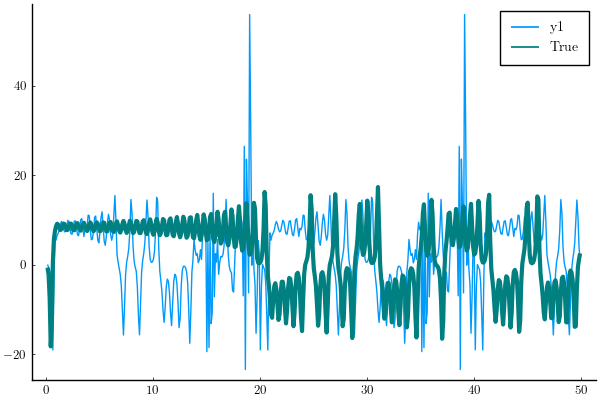

In [116]:
plot(data.tt[nb:Δ:ne], mean_hist(Xsmf)[1,:])
plot!(data.tt[nb:Δ:ne], data.xt[1,nb:Δ:ne], linewidth =  3, color = :teal, label = "True")

In [94]:
# Plot the first component of the state over time
nb = 1
ne = 499
Δ = 1
plt = plot(xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", ylabel = L"x_1")
plot!(plt, data.tt[nb:Δ:ne], data.xt[1,nb:Δ:ne], linewidth =  3, color = :teal, label = "True")
plot!(plt, data.tt[nb:Δ:ne], mean_hist(Xsmf)[1,1+nb:Δ:1+ne], linewidth = 3, grid = false,
     color = :orangered2, linestyle = :dash, label = "Stochastic Map Filter")
scatter!(plt, data.tt[nb:Δ:ne], data.yt[1,nb:Δ:ne], linewidth = 3, color = :grey, markersize = 5, alpha = 0.5, label = "Observation")
plt

LoadError: [91mBoundsError: attempt to access 3×201 Array{Float64,2} at index [1, 2:1:500][39m

In [33]:
# Plot the different component of the state over time
nb = 5500
ne = 6000
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (900, 1000))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  2, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = (i == 1), label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(Xsmf)[i,1+nb:Δ:1+ne], linewidth = 2, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

LoadError: [91mBoundsError: attempt to access 1000-element Array{Float64,1} at index [5500][39m

Talk about the benchmark of the different filters

### Benchmark of the EnKF filter

In [116]:
path = pwd()*"/lorenz63/data/"
Nx = 3
Ny = 3
Ne_array = [10, 20, 40, 60, 100, 200];
@time model, data = setup_lorenz63(path, Ne_array);

Ne 10 RMSE: 3.8254663423276716
Ne 20 RMSE: 2.0605921219961134
Ne 40 RMSE: 0.4223537564608097
Ne 60 RMSE: 0.40146546759545937
Ne 100 RMSE: 0.3877197292448612
Ne 200 RMSE: 0.4025809532902939
 15.443304 seconds (68.89 M allocations: 6.501 GiB, 6.17% gc time)


In [55]:
metric_list = benchmark_lorenz63(model, data, path, Ne_array, [1.0])

(Ne, β) = (10, 1.0)
  0.482682 seconds (3.47 M allocations: 329.564 MiB, 11.44% gc time)
Ne = 10
Ne 10& β 1.0 RMSE: 0.6015590736992926


Progress:  17%|██████▉                                  |  ETA: 0:00:05

(Ne, β) = (20, 1.0)
  

Progress:  33%|█████████████▋                           |  ETA: 0:00:04

0.859515 seconds (6.59 M allocations: 631.994 MiB, 8.56% gc time)
Ne = 20
Ne 20& β 1.0 RMSE: 0.5184477645494938
(Ne, β) = (40, 1.0)
  

Progress:  50%|████████████████████▌                    |  ETA: 0:00:04

1.662244 seconds (12.83 M allocations: 1.210 GiB, 8.65% gc time)
Ne = 40
Ne 40& β 1.0 RMSE: 0.4483744816193398
(Ne, β) = (60, 1.0)
  

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:03

2.463622 seconds (19.07 M allocations: 1.804 GiB, 8.51% gc time)
Ne = 60
Ne 60& β 1.0 RMSE: 0.4403101469791623
(Ne, β) = (100, 1.0)
  

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:02

4.334649 seconds (31.55 M allocations: 2.983 GiB, 8.49% gc time)
Ne = 100
Ne 100& β 1.0 RMSE: 0.4303647629868742
(Ne, β) = (200, 1.0)
 13.776164 seconds (62.75 M allocations: 5.935 GiB, 7.19% gc time)
Ne = 200
Ne 200& β 1.0 RMSE: 0.4465248257137066

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


6-element Array{Any,1}:
 Metrics[Metrics(10, [0.8166106052280312, 0.8477976249831615, 0.5377435004826744, 0.2946057216215732, 0.1963372890873663, 0.1661211989653268, 0.09550122139602638, 0.10895691501209233, 0.061645037116889324, 0.1556247918798692  …  4.0942175082812975, 2.918216773645667, 2.293946056603929, 2.3368525142834664, 2.9966610036699945, 2.488711153121422, 2.060789991067101, 2.000268585410395, 2.0094430111553767, 1.633586039615903], 0.37686107778341077, 0.6015590736992926, 0.8149386709205617, [1.0125271950095414, 0.9623361052178709, 0.7792957424814254, 0.4344193482216172, 0.2873587820499424, 0.2729751953413108, 0.40382950988831384, 0.6108278943470481, 0.6592219807793599, 0.4157011617649463  …  0.6622613427311322, 0.9156031963385003, 1.1880540752197546, 1.010250360884169, 0.9055102239545725, 0.6429162631150634, 0.5592022167774022, 0.6557579770729094, 0.987851621549649, 1.1234614213819019], 0.4419068954362283, 0.5053138269227165, 0.25903240927442023, [1.0, 1.0, 0.6666666666666

In [23]:
metric_list = benchmark_lorenz63(model, data, path, Ne_array, [1.0])

(Ne, β) = (200, 1.0)
  7.739944 seconds (62.75 M allocations: 5.935 GiB, 6.06% gc time)
Ne = 200
Ne 200& β 1.0 RMSE: 0.4189442707516625


1-element Array{Any,1}:
 Metrics[Metrics(200, [0.27418871478089074, 0.4011111920900346, 0.6224367042654201, 1.1940241372680338, 1.178706937442249, 0.629896584355798, 0.37352902606306937, 0.27598562967074297, 0.3415108073527272, 0.5385900049790774  …  0.22005926456584765, 0.11117371050261328, 0.0745833426310767, 0.06915409494524392, 0.23566185689849842, 0.4284533696688461, 0.7382482677445492, 1.2785156926466672, 0.9477650979445261, 0.8579855755647071], 0.2843509443072877, 0.4189442707516625, 0.3843942458358231, [0.2791191166770778, 0.3308824803118106, 0.5356751453956368, 0.7482658949655999, 0.6849666981780923, 0.5401293761758875, 0.3905840265207302, 0.30529026491290673, 0.3612676308031941, 0.5506587576884893  …  0.9550452598208562, 0.7275900415277436, 0.5097020874896808, 0.38068472189933705, 0.44668108906035564, 0.6711198461183089, 0.7934070557338772, 0.953289237580203, 1.0821830718436276, 1.1373384160933897], 0.529889526630428, 0.584733698922179, 0.23401428353181045, [1.0, 1.0, 1.0, 1.